This notebook is a backtest of the strategy outlined in the paper.

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import yaml
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
import seaborn as sns

### Development

Do a per-stock fitting and signal generation, such that data pulling doesn't take too much time. If the fitted beta (market component) does not have data for the entire period of the given stock, then the fallback will be utilised.

In [3]:
load_dotenv()

# .env variables
db_url = os.getenv('DB_URL')
constituents_table = os.getenv('CONSTITUENTS_TABLE')
prices_table = os.getenv('PRICES_TABLE')

# connection to sql database
db_conn = create_engine(db_url)

# config yaml
with open('backtest_config.yaml') as f:
    backtest_cfg = yaml.load(f, Loader=yaml.FullLoader)

sector_betas = backtest_cfg['sector_betas']
backtest_settings = backtest_cfg['backtest']

Remove any duplicate constituents besides the most recent ones (since `yfinance` will only keep the most recent ones).

In [4]:
def fetch_patched_constituents():
    constituents = pd.read_sql(
        f"""
        SELECT * FROM {constituents_table}
        WHERE sector IS NOT NULL
        """,
        db_conn
    )

    available_constituents = pd.read_sql(
        f"""
        SELECT DISTINCT ticker FROM {prices_table}
        """,
        db_conn
    )["ticker"].to_list()

    constituents['end_date'] = pd.to_datetime(constituents['end_date'])
    constituents['end_date_filled'] = constituents['end_date'].fillna(pd.Timestamp.max)

    constituents = (
        constituents.sort_values(['ticker', 'end_date_filled'], ascending=[True, False])
        .drop_duplicates(subset='ticker', keep='first')
        .drop(columns='end_date_filled')
    )

    constituents = constituents[constituents['ticker'].isin(available_constituents)]

    return constituents.set_index('ticker').to_dict(orient='index')

constituents = fetch_patched_constituents()

In [5]:
available_constituents = pd.read_sql(
    f"""
    SELECT DISTINCT ticker FROM {prices_table}
    """,
    db_conn
)["ticker"].to_list()

Now consider the generation of signals.

In [56]:
def generate_edge_leg_df(edge_leg: str, data_table: str) -> pd.DataFrame:
    """
    Generate signals for a given stock ticker (edge_leg).

    Args:
        edge_leg (str): The stock ticker for which signals are generated.

    Returns:
        pd.DataFrame: DataFrame containing sector ETF data for the given stock.
    """
    try:
        # Extract relevant config information for the given edge leg.
        edge_leg_start = constituents[edge_leg]['start_date']
        edge_leg_end = constituents[edge_leg]['end_date'] if constituents[edge_leg]['end_date'] is not pd.NaT else date.today()
        sector = constituents[edge_leg]['sector']
        sector_beta = sector_betas[sector]['beta']

        edge_data_query = f"""
            SELECT date, ticker, adj_close, volume FROM {data_table}
            WHERE ticker = '{edge_leg}'
        """
        edge_data = pd.read_sql(edge_data_query, db_conn)

        sector_etf_query = f"""
            SELECT date, ticker, adj_close, volume FROM {data_table}
            WHERE ticker = '{sector_beta}'
            AND date >= '{edge_leg_start}'
            AND date <= '{edge_leg_end}'
        """
        sector_etf_data = pd.read_sql(sector_etf_query, db_conn)

        # Ensure date column is in datetime format
        edge_data['date'] = pd.to_datetime(edge_data['date'])
        sector_etf_data['date'] = pd.to_datetime(sector_etf_data['date'])

        # We only want to test for days where the etf was also trading.
        edge_data = edge_data[edge_data['date'].isin(sector_etf_data['date'])]

        # Get (log) returns column for both edge and sector data
        edge_data['log_returns'] = np.log(edge_data['adj_close'] / edge_data['adj_close'].shift())
        sector_etf_data['log_returns'] = np.log(sector_etf_data['adj_close'] / sector_etf_data['adj_close'].shift())

        backtest_data = pd.concat([edge_data, sector_etf_data]).sort_values('date').dropna().reset_index(drop=True)

        return backtest_data
        

    except KeyError as e:
        print(f"KeyError: {e}. Check if edge_leg exists in constituents.")
        raise
    except Exception as e:
        print(f"An error occurred while generating signals: {e}")
        raise

def generate_signals(edge_leg_df: pd.DataFrame, edge_leg: str, hedge_leg: str) -> pd.DataFrame:
    """
    Returns the trading signals (as entry as well as s-score) for the edge leg.
    """
    def s_score(window_data: np.array) -> float:
        """
        Calculate s-score following Avellaneda-Lee methodology with proper exclusion criteria.
        
        The paper specifies that we should exclude stocks where:
        1. kappa = -log(b) * 252 is too small (indicating slow mean reversion)
        2. b parameter is outside acceptable bounds
        3. The half-life of mean reversion is too long
        """
        try:
            if len(window_data) < 10:  # Minimum data requirement
                return np.nan
                
            X_k = np.cumsum(window_data)                             
            X_n_plus_one = X_k[1:]                                     
            X_n = X_k[:-1]                                              

            ou_model = LinearRegression().fit(X_n.reshape(-1, 1), X_n_plus_one)

            # OU process parameters as defined in the paper
            a = ou_model.intercept_
            b = ou_model.coef_[0]  # Extract scalar value
            zeta = X_n_plus_one - ou_model.predict(X_n.reshape(-1, 1))

            # Avellaneda-Lee exclusion criteria
            if b <= 0 or b >= 0.9672:
                return np.nan
                
            kappa = -np.log(b) * 252
            
            if kappa <= 252 / 30:
                return np.nan

            
            m = a / (1 - b)  
            sigma_eq = np.sqrt(np.var(zeta) / (1 - b ** 2)) 

            s_score_value = -m / sigma_eq
            
            return s_score_value
            
        except (np.linalg.LinAlgError, ValueError, ZeroDivisionError) as e:
            # Handle numerical issues gracefully
            return np.nan
        except Exception as e:
            return np.nan
    
    def rolling_apply(series: pd.Series, window: int, func) -> pd.Series:
        result = np.full(len(series), np.nan)
        arr = series.to_numpy()
        for i in range(window, len(arr)):
            result[i] = func(arr[i - window:i])
        return pd.Series(result, index=series.index)

    def fill_positions_from_s_score(s_score_series: pd.Series) -> pd.Series:
        """
        Implements Avellaneda & Lee threshold logic:
        - Entry short at >= +1.25, exit short at < +0.75
        - Entry long at <= -1.25, exit long at > -0.5
        """
        position = 0
        positions = []

        for score in s_score_series:
            if pd.isna(score):  # Skip NaN values
                positions.append(0)
                continue
                
            if position == 0:
                if score >= 1.25:
                    position = -1  # Enter short
                elif score <= -1.25:
                    position = 1   # Enter long
            elif position == -1:
                if score < 0.75:
                    position = 0  # Exit short
            elif position == 1:
                if score > -0.5:
                    position = 0  # Exit long

            positions.append(position)

        return pd.Series(positions, index=s_score_series.index, name='position')

    W = backtest_settings['lookback']

    wide = (edge_leg_df
            .pivot(index='date', columns='ticker', values='log_returns')
            [[edge_leg, hedge_leg]]
            .sort_index()
            .dropna())
    y = wide[edge_leg]
    x = wide[hedge_leg]

    """
    Below is an efficient implementation for finding OLS residuals.
    It finds the rolling means, the rolling residual from the mean, and from this calculates
    the variance and covariance. This then allows us to find the beta and alpha.
    """
    mx = x.rolling(W, min_periods=W).mean()
    my = y.rolling(W, min_periods=W).mean()

    x_dev = x - mx
    y_dev = y - my

    var_x = (x_dev.pow(2)).rolling(W, min_periods=W).sum()
    cov_xy = (x_dev * y_dev).rolling(W, min_periods=W).sum()

    beta = (cov_xy / var_x).shift(1)
    alpha = (my - beta * mx).shift(1)

    fitted = alpha + beta * x
    residual = (y - fitted).dropna()

    """
    We then calculate the s-score. This is an estimation of the residual process and can be 
    found in the appendix of the paper.
    """

    s_score_results = rolling_apply(residual, W, s_score)
    s_score_results.name = 's_score'
    s_score_df = s_score_results.dropna().reset_index()

    s_score_df['edge_leg'] = edge_leg
    s_score_df['hedge_leg'] = hedge_leg
    s_score_df['signal'] = fill_positions_from_s_score(s_score_df['s_score'])
    
    # merge beta values to the s-score df
    beta_frame = beta.to_frame(name='beta').reset_index()
    s_score_df = s_score_df.merge(beta_frame, on='date', how='left')

    wide_returns = wide.rename(columns={
        edge_leg: 'log_return_edge',
        hedge_leg: 'log_return_hedge'
    })
    
    wide_volume = (edge_leg_df
                   .pivot(index='date', columns='ticker', values='volume')
                   [[edge_leg, hedge_leg]]
                   .sort_index()
                   .rename(columns={
                       edge_leg: 'volume_edge',
                       hedge_leg: 'volume_hedge'
                   }))

    final_df = pd.merge(s_score_df, wide_returns, on='date', how='left')
    final_df = pd.merge(final_df, wide_volume, on='date', how='left')

    return final_df

In [7]:
msft = generate_edge_leg_df('MSFT')
msft_pos = generate_signals(msft, 'MSFT', 'XLK')

### Filling in all constituents

We now consider the performance of the strategy across ~25 years, across the entire universe available to us.

In [ ]:
positions = []
completed_count = 0
failed_count = 0
total_tickers = len(available_constituents)

print(f"🚀 Starting backtest for {total_tickers} tickers...")
print("=" * 60)

for i, ticker in enumerate(available_constituents, 1):
    try:
        edge_leg = ticker
        sector = constituents[ticker]['sector']
        hedge_leg = sector_betas[sector]['beta']

        edge_leg_df = generate_edge_leg_df(edge_leg, 'adjusted_historical')
        position_df = generate_signals(edge_leg_df, edge_leg, hedge_leg)
        positions.append(position_df)
        
        completed_count += 1
        print(f"✅ [{i:3d}/{total_tickers}] {ticker:6s} | Sector: {sector:20s}\t| Hedge: {hedge_leg}")
        
    except Exception as e:
        failed_count += 1
        print(f"❌ [{i:3d}/{total_tickers}] {ticker:6s} | ERROR: {str(e)[:50]}...")

print("=" * 60)
print(f"🎯 BACKTEST COMPLETE!")
print(f"   ✅ Successfully processed: {completed_count:3d} tickers")
print(f"   ❌ Failed to process:     {failed_count:3d} tickers")
print(f"   📊 Success rate:          {completed_count/total_tickers*100:.1f}%")
print("=" * 60)

🚀 Starting backtest for 713 tickers...
✅ [  1/713] CLF    | Sector: Materials           	| Hedge: XLB
✅ [  2/713] VFC    | Sector: Consumer Discretionary	| Hedge: XLY
❌ [  3/713] BDK    | ERROR: 'BDK'...
✅ [  4/713] RSG    | Sector: Industrials         	| Hedge: XLI
✅ [  5/713] TKO    | Sector: Communication Services	| Hedge: XLC
✅ [  6/713] BBWI   | Sector: Consumer Discretionary	| Hedge: XLY
✅ [  7/713] EXPD   | Sector: Industrials         	| Hedge: XLI
✅ [  8/713] INVH   | Sector: Real Estate         	| Hedge: XLRE
❌ [  9/713] DDR    | ERROR: 'DDR'...
✅ [ 10/713] GWW    | Sector: Industrials         	| Hedge: XLI
❌ [ 11/713] COV    | ERROR: 'COV'...
✅ [ 12/713] ANSS   | Sector: Technology          	| Hedge: XLK
✅ [ 13/713] O      | Sector: Real Estate         	| Hedge: XLRE
✅ [ 14/713] IFF    | Sector: Materials           	| Hedge: XLB
✅ [ 15/713] BR     | Sector: Technology          	| Hedge: XLK
✅ [ 16/713] V      | Sector: Financials          	| Hedge: XLF
✅ [ 17/713] SOLV   | Se

In [9]:
strategy_history = pd.concat(positions).sort_values('date').reset_index(drop=True)

In [10]:
strategy_history

,date,s_score,edge_leg,hedge_leg,signal,beta,log_return_edge,log_return_hedge,volume_edge,volume_hedge
0,1999-09-13,-0.712738,SNT,XLI,0,0.355003,0.051314,-0.007415,3008.0,7500.0
1,1999-09-13,1.187941,SRE,XLU,0,0.638236,0.000000,0.009088,702600.0,7100.0
2,1999-09-13,2.462275,FE,XLU,-1,0.350739,0.000000,0.009088,154500.0,7100.0
3,1999-09-13,-2.083770,AXP,XLF,1,1.057749,0.001786,-0.009423,3495259.0,65982.0
4,1999-09-13,-1.742819,BAX,XLV,1,0.552595,0.000000,-0.001680,1788347.0,5500.0
...,...,...,...,...,...,...,...,...,...,...
1794053,2025-07-17,-0.444581,BAX,XLV,0,1.011809,-0.017064,-0.011462,5476800.0,15740900.0
1794054,2025-07-17,-4.023442,STX,XLK,1,1.128454,-0.002723,0.009043,5155500.0,5977500.0
1794055,2025-07-17,1.583819,MKTX,XLF,-1,-0.081908,-0.023947,0.009568,510100.0,48213900.0
1794056,2025-07-17,0.981876,SW,XLY,0,0.950310,0.004568,0.003411,2920600.0,3871200.0


First, let us complete a strategy-wide analysis of returns, dividing by total, long and short returns. We take volume weighted returns as a proxy for the different weightings of the trades in our portfolio.

In [53]:
def get_portfolio_performance(backtest: pd.DataFrame, 
                                            max_volume_participation=0.1,  # 5% of daily volume
                                            transaction_cost=0.003):
    """
    Use volume to determine realistic position sizes, not as a multiplier.
    """
    backtest_grouped = backtest.groupby('date')
    portfolio_results = []
    per_stock_results = []

    for date, data in backtest_grouped:
        if len(data) == 0:
            portfolio_results.append({'date': date, 'portfolio_return': 0, 'total_capacity': 0})
            continue

        longs = data[data['signal'] == 1].copy()
        shorts = data[data['signal'] == -1].copy()

        # 'volume-informed' weighting of trades.
        for df in [longs, shorts]:
            if len(df) > 0:
                df['max_position_size'] = df['volume_edge'] * max_volume_participation
                df['capacity_weight'] = df['max_position_size'] / df['max_position_size'].sum()
            per_stock_results.append(df)
            
        
        if len(longs) > 0:
            long_return = ((longs['log_return_edge'] - longs['log_return_hedge']) * longs['capacity_weight']).sum()
        else:
            long_return = 0
            
        if len(shorts) > 0:
            short_return = ((shorts['log_return_hedge'] - shorts['log_return_edge']) * shorts['capacity_weight']).sum()
        else:
            short_return = 0

        portfolio_return = (long_return + short_return) - transaction_cost
        total_capacity = (longs['max_position_size'].sum() if len(longs) > 0 else 0) + \
                        (shorts['max_position_size'].sum() if len(shorts) > 0 else 0)

        portfolio_results.append({
            'date': date,
            'vw_long_return': long_return,
            'vw_short_return': short_return,
            'portfolio_return': portfolio_return,
            'total_capacity': total_capacity,
            'total_positions': len(data)
        })

    return pd.DataFrame(portfolio_results), pd.concat(per_stock_results)

In [ ]:
# just 0 tc cost for now
positions, per_stock_positions = get_portfolio_performance(strategy_history, transaction_cost=0)

Fetch volatility for `SPY` so we can get a proxy for market volatility.

In [29]:
spy = pd.read_sql(
    """
    select * from adjusted_historical
    where ticker = 'SPY'
    """,
    db_conn
)
spy['date'] = pd.to_datetime(spy['date'])
spy = spy[spy['date'].isin(positions['date'])]
spy['log_return'] = np.log(spy['adj_close'] / spy['adj_close'].shift())
spy['volatility'] = spy['log_return'].rolling(15).std()
spy['rolling_volatility'] = spy['volatility'].rolling(30).mean()

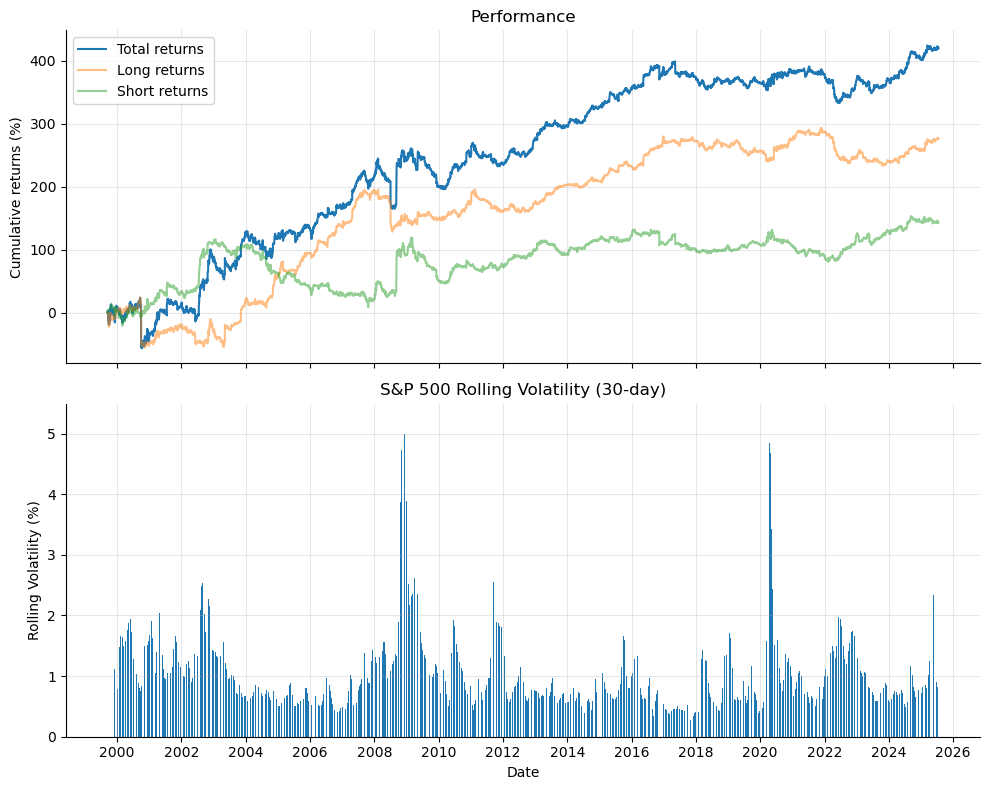

In [21]:
from matplotlib.dates import YearLocator, DateFormatter

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top plot - Cumulative returns
ax1.plot(positions['date'], positions['portfolio_return'].cumsum() * 100, label='Total returns')
ax1.plot(positions['date'], positions['vw_long_return'].cumsum() * 100, label='Long returns', alpha=0.5)
ax1.plot(positions['date'], positions['vw_short_return'].cumsum() * 100, label='Short returns', alpha=0.5)
ax1.grid(alpha=0.3)
ax1.legend()
ax1.set_ylabel('Cumulative returns (%)')
ax1.set_title('Performance')

# Bottom plot - SPY rolling volatility
ax2.bar(spy['date'], spy['rolling_volatility'] * 100)
ax2.grid(alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Rolling Volatility (%)')
ax2.set_title('S&P 500 Rolling Volatility (30-day)')

# Set x-axis ticks every 2 years
ax2.xaxis.set_major_locator(YearLocator(base=2))  # Every 2 years
ax2.xaxis.set_major_formatter(DateFormatter('%Y'))  # Format as year only

# Remove spines for both plots
sns.despine(ax=ax1)
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

We see pretty strong performance from ~2002 to ~2016 (with large drops in volatile periods). We then see performance stagnations post-2016. Clearly there are some improvements to make to the backtester considering we have very sharp increases and decreases - which are either data issues or just inappropiate backtesting practices.

### Comparison to the S & P 500

We now consider the performance relative to the S & P 500.

In [22]:
spy['log_return'] = np.log(spy['adj_close'] / spy['adj_close'].shift())

Text(0.5, 1.0, 'Statistical arbitrage (without fees) outperforms the S & P 500 for our testing history')

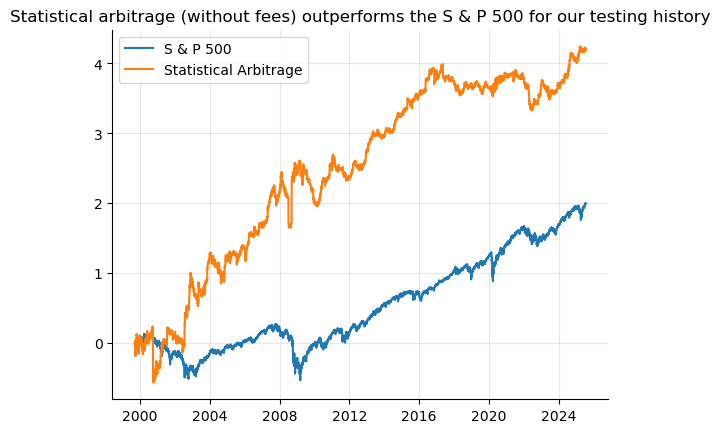

In [23]:
plt.plot(spy['date'], spy['log_return'].cumsum(), label='S & P 500')
plt.plot(positions['date'], positions['portfolio_return'].cumsum(), label = 'Statistical Arbitrage')
plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.title('Statistical arbitrage (without fees) outperforms the S & P 500 for our testing history')

Now let us see the correlation between the returns of our statistical arbitrage strategy and the S & P 500.

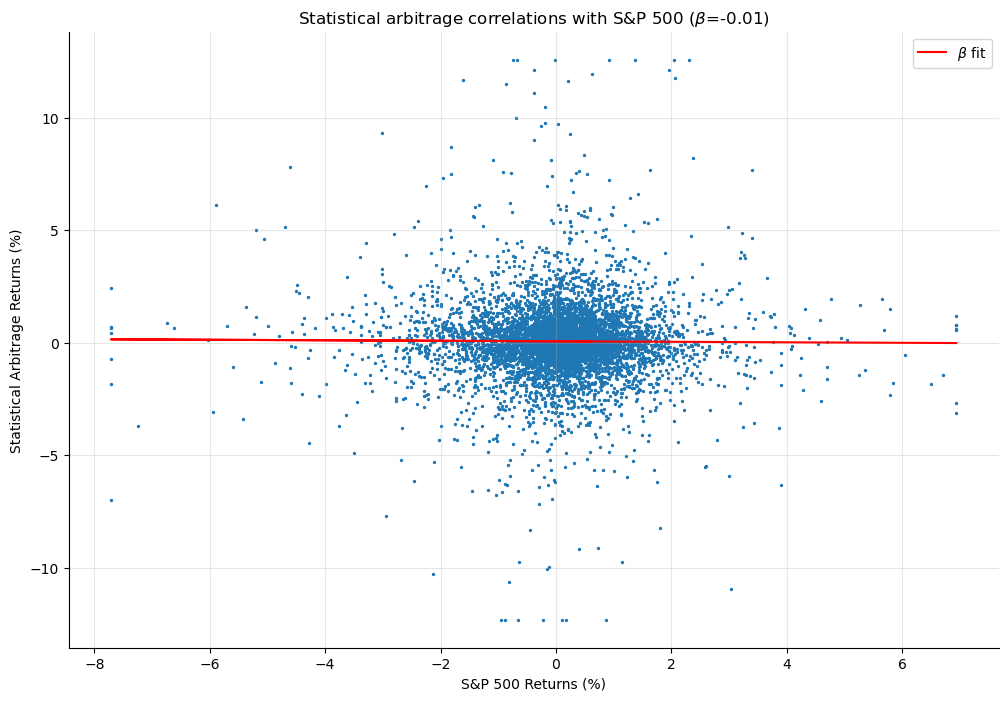

In [78]:
from sklearn.linear_model import LinearRegression
import numpy as np

positions['portfolio_return_winsorized'] = winsorize(positions['portfolio_return'], limits=(0.001, 0.001))
spy['log_return_winsorized'] = winsorize(spy['log_return'], limits=(0.001, 0.001))

X = spy['log_return_winsorized'].values.reshape(-1, 1) 
Y = positions['portfolio_return_winsorized'].values 

valid_indices = ~np.isnan(X).flatten() & ~np.isnan(Y)
X = X[valid_indices]
Y = Y[valid_indices]

reg = LinearRegression().fit(X, Y)
beta = reg.coef_[0] 

reg_line = reg.predict(X)

plt.figure(figsize=(12, 8))
plt.scatter(X * 100, Y * 100, s=2)
plt.plot(X * 100, reg_line * 100, color='red', label=f'$\\beta$ fit')

plt.xlabel('S&P 500 Returns (%)')
plt.ylabel('Statistical Arbitrage Returns (%)')
plt.title(f'Statistical arbitrage correlations with S&P 500 ($\\beta$={beta:.2f})')
plt.grid(alpha=0.3)
sns.despine()
plt.legend()
plt.show()

So we have a 0 beta strategy.

### A more realistic backtest - removing the ETF hedge, and hedging across intra-sector stocks

You can imagine a clear issue with the above backtest - we naively take the `edge_leg - hedge_leg` (or flipped for shorts) for every stock that is signalled for a trade. If we did this however, longing and shorting the `ETF`s would cancel out; such that the returns of the `ETF`s would not be reflected.

Furthermore, we add a `3 bp` transaction cost, simulating an institutional traders trading costs.

In [25]:
# if not generated by backtest

per_stock_positions = pd.read_sql(
    """
    select * from per_stock_positions;
    """,
    db_conn
)

In [26]:
ex_etf_results = []
transaction_cost = 0
max_volume_participation = 0.1

for day, day_data in per_stock_positions.groupby('date'):
    for sector, sector_data in day_data.groupby('date'):
        longs = sector_data[sector_data['signal'] == 1].sort_values('volume_edge', ascending=False)
        shorts = sector_data[sector_data['signal'] == -1].sort_values('volume_edge', ascending=False)


        num_pairs = min(len(longs), len(shorts))
        matched_longs = longs.head(num_pairs).copy()
        matched_shorts = shorts.head(num_pairs).copy()

        if len(matched_longs) > 0:
            matched_longs['max_position_size'] = matched_longs['volume_edge'] * max_volume_participation
            matched_longs['capacity_weight'] = matched_longs['max_position_size'] / matched_longs['max_position_size'].sum()

        if len(matched_shorts) > 0:
            matched_shorts['max_position_size'] = matched_shorts['volume_edge'] * max_volume_participation
            matched_shorts['capacity_weight'] = matched_shorts['max_position_size'] / matched_shorts['max_position_size'].sum()

        long_return = ((matched_longs['log_return_edge']) * matched_longs['capacity_weight']).sum() if len(matched_longs) > 0 else 0
        short_return = ((matched_shorts['log_return_edge']) * matched_shorts['capacity_weight']).sum() if len(matched_shorts) > 0 else 0
        portfolio_return = long_return - short_return - transaction_cost

        ex_etf_results.append({
            'date': day,
            'sector': sector,
            'long_return': long_return,
            'short_return': short_return,
            'portfolio_return': portfolio_return,
            'num_pairs': num_pairs,
            'total_long_volume': matched_longs['volume_edge'].sum() if len(matched_longs) > 0 else 0,
            'total_short_volume': matched_shorts['volume_edge'].sum() if len(matched_shorts) > 0 else 0
        })

ex_etf_df = pd.DataFrame(ex_etf_results)

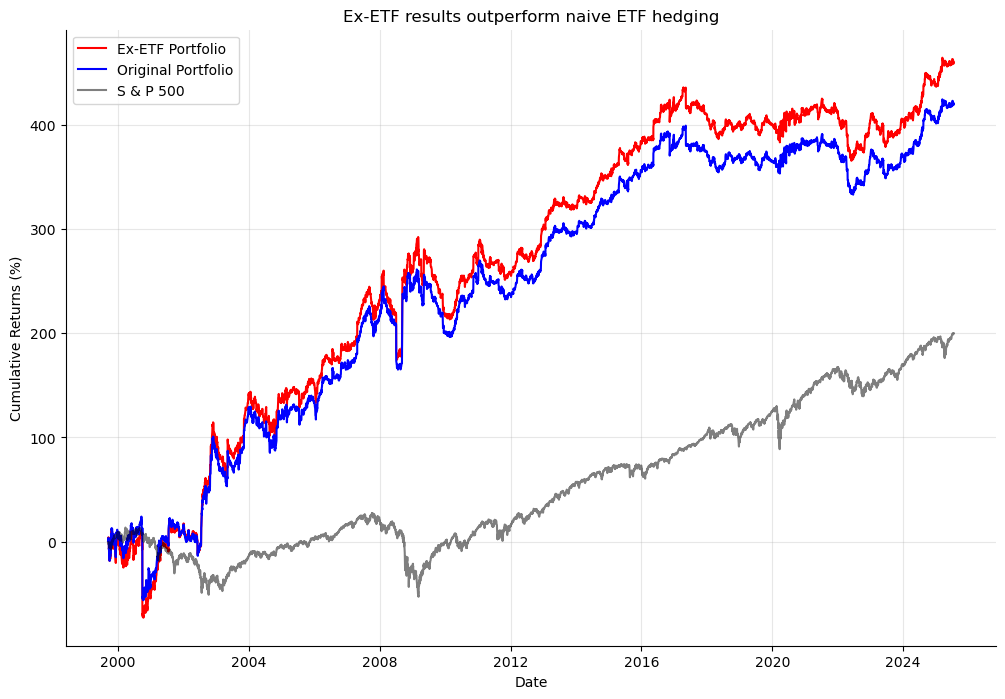

In [79]:
plt.figure(figsize=(12, 8))
plt.plot(ex_etf_df['date'], ex_etf_df['portfolio_return'].cumsum() * 100, label='Ex-ETF Portfolio', color='red')
plt.plot(positions['date'], positions['portfolio_return'].cumsum() * 100, label='Original Portfolio', color='blue')
plt.plot(spy['date'], spy['log_return'].cumsum() * 100, label='S & P 500', color='black', alpha=0.5)

plt.xlabel('Date')
plt.title('Ex-ETF results outperform naive ETF hedging')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.grid(alpha=0.3)
sns.despine()

With this, we essentially create an alpha model that we take long-short returns over. Consider our correlations to the S & P 500 with this 'new' strategy.

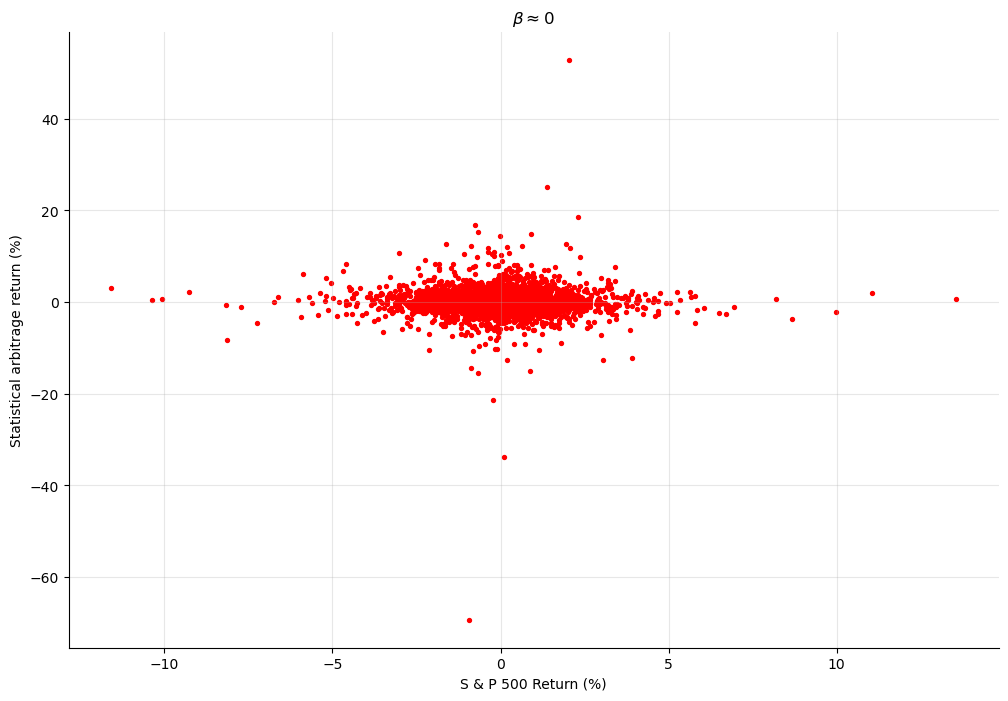

In [80]:
plt.figure(figsize=(12, 8))
plt.scatter(spy['log_return'] * 100, ex_etf_df['portfolio_return'] * 100, s=8, color='red')
sns.despine()
plt.grid(alpha=0.3)
plt.xlabel('S & P 500 Return (%)');
plt.ylabel('Statistical arbitrage return (%)');
plt.title('$\\beta \\approx 0$');

### Week-to-week returns

Whilst thus far, we have considered no transaction costs, daily rebalancing portfolios are subject to large transaction costs. In this section, we consider week-to-week rebalancing, on the close of the Friday.

In [51]:
backtest_settings['lookback'] = 30

In [58]:
week_to_week_positions = []
completed_count = 0
failed_count = 0
total_tickers = len(available_constituents)

print(f"🚀 Starting backtest for {total_tickers} tickers...")
print("=" * 60)

for i, ticker in enumerate(available_constituents, 1):
    try:
        edge_leg = ticker
        sector = constituents[ticker]['sector']
        hedge_leg = sector_betas[sector]['beta']

        edge_leg_df = generate_edge_leg_df(edge_leg, 'adjusted_week_to_week')
        position_df = generate_signals(edge_leg_df, edge_leg, hedge_leg)
        week_to_week_positions.append(position_df)
        
        completed_count += 1
        print(f"✅ [{i:3d}/{total_tickers}] {ticker:6s} | Sector: {sector:20s}\t| Hedge: {hedge_leg}")
        
    except Exception as e:
        failed_count += 1
        print(f"❌ [{i:3d}/{total_tickers}] {ticker:6s} | ERROR: {str(e)[:50]}...")

print("=" * 60)
print(f"🎯 BACKTEST COMPLETE!")
print(f"   ✅ Successfully processed: {completed_count:3d} tickers")
print(f"   ❌ Failed to process:     {failed_count:3d} tickers")
print(f"   📊 Success rate:          {completed_count/total_tickers*100:.1f}%")
print("=" * 60)

🚀 Starting backtest for 713 tickers...
✅ [  1/713] CLF    | Sector: Materials           	| Hedge: XLB
✅ [  2/713] VFC    | Sector: Consumer Discretionary	| Hedge: XLY
❌ [  3/713] BDK    | ERROR: 'BDK'...
✅ [  4/713] RSG    | Sector: Industrials         	| Hedge: XLI
✅ [  5/713] TKO    | Sector: Communication Services	| Hedge: XLC
✅ [  6/713] BBWI   | Sector: Consumer Discretionary	| Hedge: XLY
✅ [  7/713] EXPD   | Sector: Industrials         	| Hedge: XLI
✅ [  8/713] INVH   | Sector: Real Estate         	| Hedge: XLRE
❌ [  9/713] DDR    | ERROR: 'DDR'...
✅ [ 10/713] GWW    | Sector: Industrials         	| Hedge: XLI
❌ [ 11/713] COV    | ERROR: 'COV'...
✅ [ 12/713] ANSS   | Sector: Technology          	| Hedge: XLK
✅ [ 13/713] O      | Sector: Real Estate         	| Hedge: XLRE
✅ [ 14/713] IFF    | Sector: Materials           	| Hedge: XLB
✅ [ 15/713] BR     | Sector: Technology          	| Hedge: XLK
✅ [ 16/713] V      | Sector: Financials          	| Hedge: XLF
✅ [ 17/713] SOLV   | Se

In [59]:
week_to_week = pd.concat(week_to_week_positions)

In [64]:
portfolio, week_to_week_positions = get_portfolio_performance(week_to_week, transaction_cost=0)

In [65]:
week_to_week_portfolio = []
transaction_cost = 0
max_volume_participation = 0.1

for day, day_data in week_to_week_positions.groupby('date'):
    for sector, sector_data in day_data.groupby('date'):
        longs = sector_data[sector_data['signal'] == 1].sort_values('volume_edge', ascending=False)
        shorts = sector_data[sector_data['signal'] == -1].sort_values('volume_edge', ascending=False)


        num_pairs = min(len(longs), len(shorts))
        matched_longs = longs.head(num_pairs).copy()
        matched_shorts = shorts.head(num_pairs).copy()

        if len(matched_longs) > 0:
            matched_longs['max_position_size'] = matched_longs['volume_edge'] * max_volume_participation
            matched_longs['capacity_weight'] = matched_longs['max_position_size'] / matched_longs['max_position_size'].sum()

        if len(matched_shorts) > 0:
            matched_shorts['max_position_size'] = matched_shorts['volume_edge'] * max_volume_participation
            matched_shorts['capacity_weight'] = matched_shorts['max_position_size'] / matched_shorts['max_position_size'].sum()

        long_return = ((matched_longs['log_return_edge']) * matched_longs['capacity_weight']).sum() if len(matched_longs) > 0 else 0
        short_return = ((matched_shorts['log_return_edge']) * matched_shorts['capacity_weight']).sum() if len(matched_shorts) > 0 else 0
        portfolio_return = long_return - short_return - transaction_cost

        week_to_week_portfolio.append({
            'date': day,
            'sector': sector,
            'long_return': long_return,
            'short_return': short_return,
            'portfolio_return': portfolio_return,
            'num_pairs': num_pairs,
            'total_long_volume': matched_longs['volume_edge'].sum() if len(matched_longs) > 0 else 0,
            'total_short_volume': matched_shorts['volume_edge'].sum() if len(matched_shorts) > 0 else 0
        })

wtw_df = pd.DataFrame(week_to_week_portfolio)

Text(0.5, 1.0, 'Week-to-week rebalancing is ineffective, as it fails to adjust during the GFC')

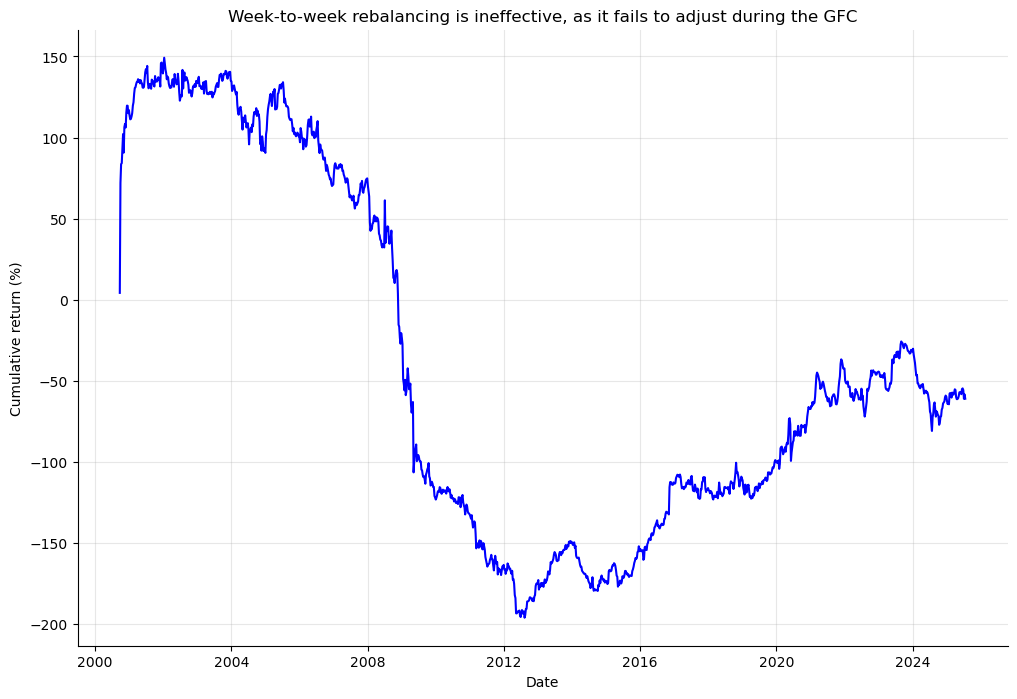

In [82]:
plt.figure(figsize=(12, 8))
plt.plot(wtw_df['date'], wtw_df['portfolio_return'].cumsum() * 100, color='blue')
plt.grid(alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Cumulative return (%)')
sns.despine()
plt.title('Week-to-week rebalancing is ineffective, as it fails to adjust during the GFC')

We can see the naive week-to-week backtest fails to recover (and take advantage of more inefficiencies during the general crash), unlike the daily backtest.